<a href="https://colab.research.google.com/github/CodeMonkey01/DataMiningI/blob/main/ANN/Option%202%20(Stemming%20%2B%20No%20stop%20words)/ANN_with_BERT_with_Stemming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN with BERT
In this notebook I tried to solve the classification model with an ANN based on pretrained BERT layers.

## TODO:
- [x] Stemming
- [ ] Remove Stop Words

## Results


Training time:

## Model
Link to model: (hosted on OneDrive)

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/MyDrive
Sat May 14 14:51:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [2]:
!pip install tensorflow_text
!pip install tensorflow_hub

     |████████████████████████████████| 4.9 MB 11.9 MB/s 
     |████████████████████████████████| 462 kB 45.1 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [103]:
df_raw = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset.txt')
df_raw.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


In [104]:
# todo --> take random sample to speed up training
df = df_raw.sample(5000)

# Check for imbalance
The dataset is equally balanced. Therefore, we do not need to rebalance the dataset.

In [47]:
df["humor"].value_counts()

False    2504
True     2496
Name: humor, dtype: int64

# Preprocessing

In [107]:
# Transform class from Boolean to integer value
df['class']=df['humor'].apply(lambda x: 1 if x==True else 0)

In [83]:
# Stemming
import nltk
from nltk.stem import PorterStemmer
import re

token_pattern = re.compile(r"(?u)\b\w\w+\b")

ps = PorterStemmer()

nltk.download('punkt')

df['stemmed']=df['text'].apply(lambda x: ' '.join([ps.stem(y) for y in token_pattern.findall(x)]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
df = df.drop(["text", "humor"], axis=1)
df.head(25)

,class,stemmed
9750,0,photo of seal cheesin for the camera win photo...
28828,0,clinton campaign deni access to daili mail poo...
60567,1,what white plastic and not suitabl for age and...
39945,0,nation french fri day is there such thing as h...
136710,1,what do you call short psychic who escap from ...
133504,0,republican insist they re be transpar with the...
100036,0,celeb do rock and roll chic on thi week best b...
122189,1,went on date with girl call simil but don know...
159005,0,On the souleo dna test inspir new photo seri o...
9270,0,trippi fractal captur the kaleidoscop beauti o...


In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['class'], random_state=42, test_size=0.2)

# BERT

In [106]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [109]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# Build model

In [110]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [111]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [112]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
125/125 [==============================] - 42s 252ms/step - loss: 0.5884 - accuracy: 0.7085 - precision: 0.6961 - recall: 0.7292
Epoch 2/5
125/125 [==============================] - 31s 251ms/step - loss: 0.4582 - accuracy: 0.8080 - precision: 0.7876 - recall: 0.8378
Epoch 3/5
125/125 [==============================] - 31s 252ms/step - loss: 0.4045 - accuracy: 0.8388 - precision: 0.8134 - recall: 0.8747
Epoch 4/5
 92/125 [=====================>........] - ETA: 8s - loss: 0.3809 - accuracy: 0.8519 - precision: 0.8317 - recall: 0.8816

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
model.save_weights("/content/drive/MyDrive/Data Mining/stemmed/model.h5")

In [34]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [35]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, ..., 0, 1, 1])

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[512, 115],
       [ 76, 547]])

Text(33.0, 0.5, 'Truth')

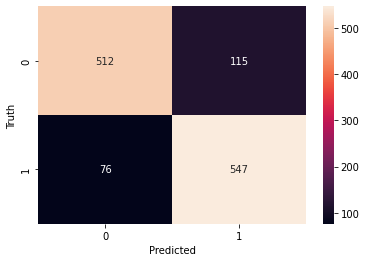

In [37]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       627
           1       0.83      0.88      0.85       623

    accuracy                           0.85      1250
   macro avg       0.85      0.85      0.85      1250
weighted avg       0.85      0.85      0.85      1250



# Own test

In [ ]:
jokes = [
    'What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
    'I study Business Informatics at the University of Mannheim!',
    'I invented a new word! Plagiarism!',
    'Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them.',
    'My name is Elias.'
]
model.predict(jokes)